# Data Exploration 

## Data Loading

In [2]:
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import nltk


def remove_empty(text):
    return [lab for lab in text if lab != '']

def remove_space(text):
    return [lab.strip() for lab in text]

df = pd.read_csv('Evaluation-dataset.csv',header = None)
df = df.fillna('')
columns = ['text']
labels = []
for idx in range(1, 15):
    name = 'label_' + str(idx)
    labels.append(name)
    columns.append(name)

df.columns = columns
df['target'] = df[labels].values.tolist()
df['target'] = df['target'].map(remove_empty)
df['target'] = df['target'].map(remove_space)
df =  df[['text','target']]
df["target_counts"] = df["target"].apply(lambda label: len(label))
print("There are {} Rows in Data".format(df.shape[0]))


There are 10132 Rows in Data


## Distribution of Count of Labels per Datapoint

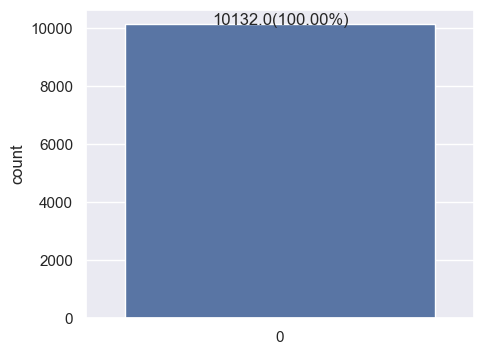

In [3]:
sns.set(rc={'figure.figsize':(5,4)})
ax=sns.countplot(df.target_counts)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{}({:1.2f}%)'.format(height,(height/len(df.target_counts))*100),
            ha="center") 

#### There are 5666.0 datapoints that doesn't have any labels

In [4]:
df[df.target_counts == 14]

,text,target,target_counts
384,"test review, should be deleted","[refund not actioned positive, refund timescal...",14


#### As we can see this datapoint is just for testing so we can easily drop it 

In [5]:
df = df.drop([384])
print("Shape of dataframe after removing outlier datapoint {}".format(df.shape))


Shape of dataframe after removing outlier datapoint (10131, 3)


In [6]:
print("Number of Unique labels - {}".format(len(df.target.explode().unique())))


Number of Unique labels - 99


In [7]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.DataFrame.from_dict(dict(df.target.explode().value_counts()),orient = 'index',columns = ['Count'])

,Count
value for money positive,4780
garage service positive,2031
ease of booking positive,1187
location positive,1063
length of fitting positive,657
delivery punctuality positive,453
tyre quality positive,434
garage service negative,423
change of date negative,277
wait time positive,274


#### There are 99 distinct labels in the dataset, but many of them do not have any sentiment associated with them and are available in extremely low counts, so we can simply treat them as noise and eliminate them.

In [8]:
def get_noisy_labels(df):
    noisy_labels = []
    for label,count in Counter(df.target.explode()).items():
        if count < 5:
            if 'positive' not in label.split():
                if 'negative' not in label.split():
                    noisy_labels.append(label)
    return noisy_labels

# to remove nosiy labels from the dataframe
def remove_noisy_labels(df):
    #print("Removing noisy labels...")
    noisy_labels = get_noisy_labels(df)
    print("Number of Noisy Labels - {}".format(len(noisy_labels)))
    for i in range(len(df)):
        for nLabel in noisy_labels:
            if nLabel in df.iloc[i,1]:
                df.iloc[i,1].remove(nLabel)
    
    # to remove datapoints that doesn't have any labels 
    df = df[df["target"].str.len() != 0]

    return df 

df = remove_noisy_labels(df)


Number of Noisy Labels - 44


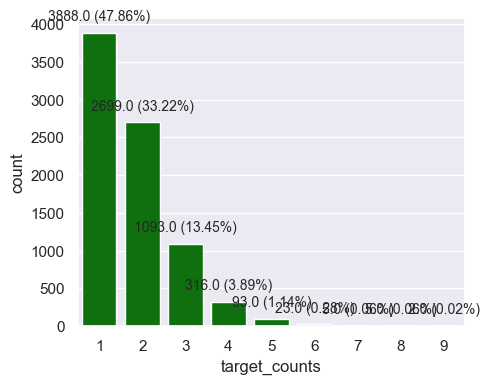

In [9]:
ax = sns.countplot(x='target_counts', data=df,color = 'green')

# Calculate total number of counts for percentage calculation
total_counts = len(df)

# Annotate each bar with the count and percentage
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 0.02 * total_counts,
            '{} ({:.2f}%)'.format(height, (height / total_counts) * 100),
            ha="center",fontsize=10)


#### So we've deleted datapoints with no labels, as well as some noisy labels with no sentiments associated with them.

In [10]:
print("Number of Unique labels after removing noisy labels - {}".format(len(df.target.explode().unique())))


Number of Unique labels after removing noisy labels - 54


#### After removing noisy labels, we end up with 54 labels. 

## Count of Each Labels 

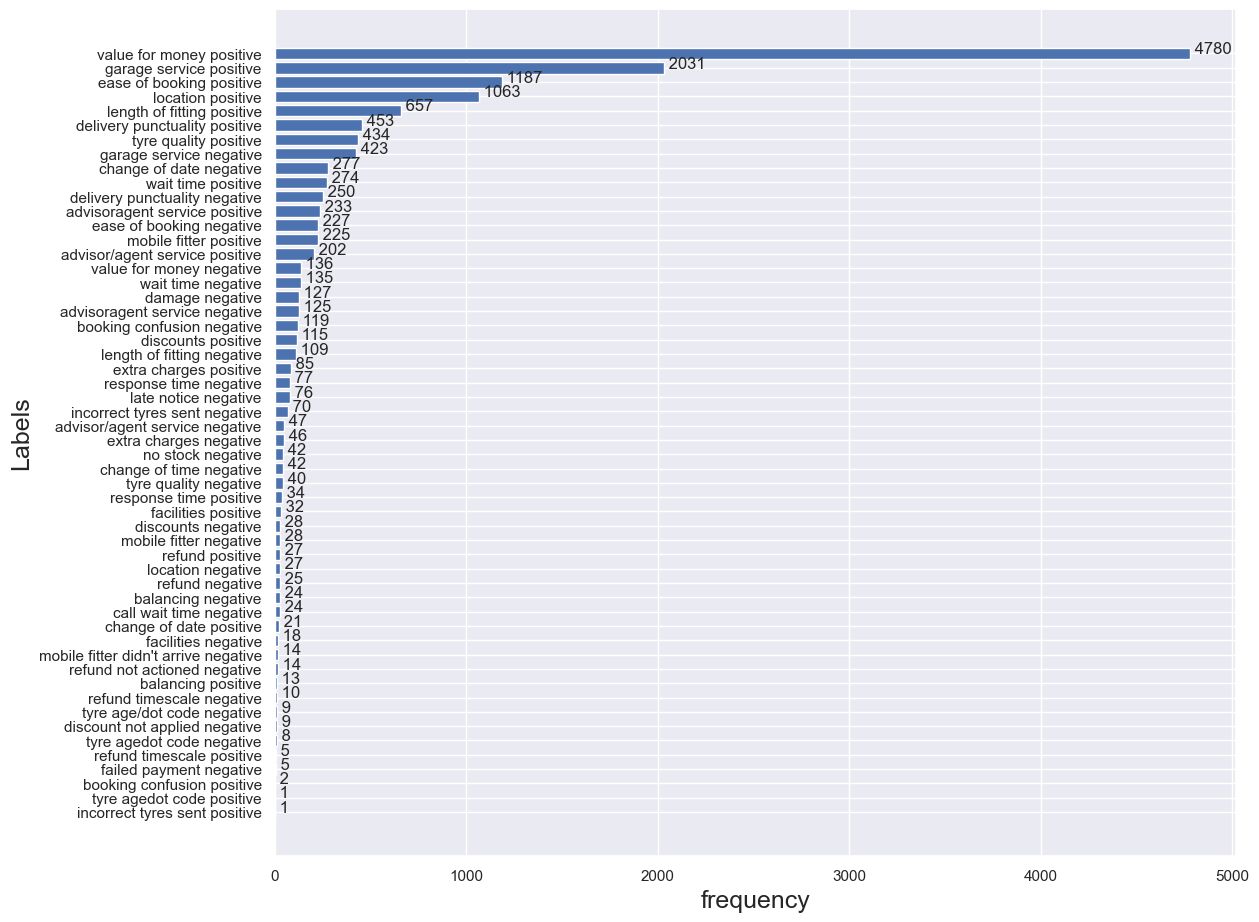

In [11]:
d = dict(Counter(df.target.explode()))
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}

sns.set(rc={'figure.figsize':(12.4,11.00)})
plt.barh(range(len(d)), d.values(), align='center')
plt.yticks(range(len(d)), d.keys())
plt.xlabel('frequency', fontsize=18)
plt.ylabel('Labels', fontsize=18)

for index, value in enumerate(d.values()):
    plt.text(value, index, ' '+str(value))

plt.show()

#### As there are a lot of labels that are less than 100, we can combine them to their respective sentiment labels as due to their low frequencies, it will be very difficult for the model to learn, and we can also there are some labels like 'advisor/agent service positive', 'advisoragent service positive' are same but due to some characters they are split, so we can fix this as well.

In [12]:
def replace_label(df, src, trg):
    def replace(texts):
        return [lab if lab != src else trg for lab in texts]
    
    df['target'] = df['target'].map(replace)
    
def combine_labels(df,min_samples = 100):
    label_counts = df.target.explode().value_counts()
    label_names = label_counts.index
    
    fewer_labels = []
    for i,label in enumerate(label_names):
        if label_counts[i] < min_samples:
            fewer_labels.append(label)
    
    def replace_fewer(labels):
        fewers = []
        for label in labels:
            sentiment = label.split(' ')[-1]
            if label in fewer_labels:
                fewers.append(' '.join(['extra',sentiment]))
            else:
                fewers.append(label)
                
        return fewers 
    
    df['target'] = df['target'].map(replace_fewer)  

    return df

replace_label(df, 'advisor/agent service positive','advisoragent service positive')
replace_label(df, 'advisor/agent service negative','advisoragent service negative')
replace_label(df, 'tyre age/dot code negative','tyre agedot code negative')

df = combine_labels(df)


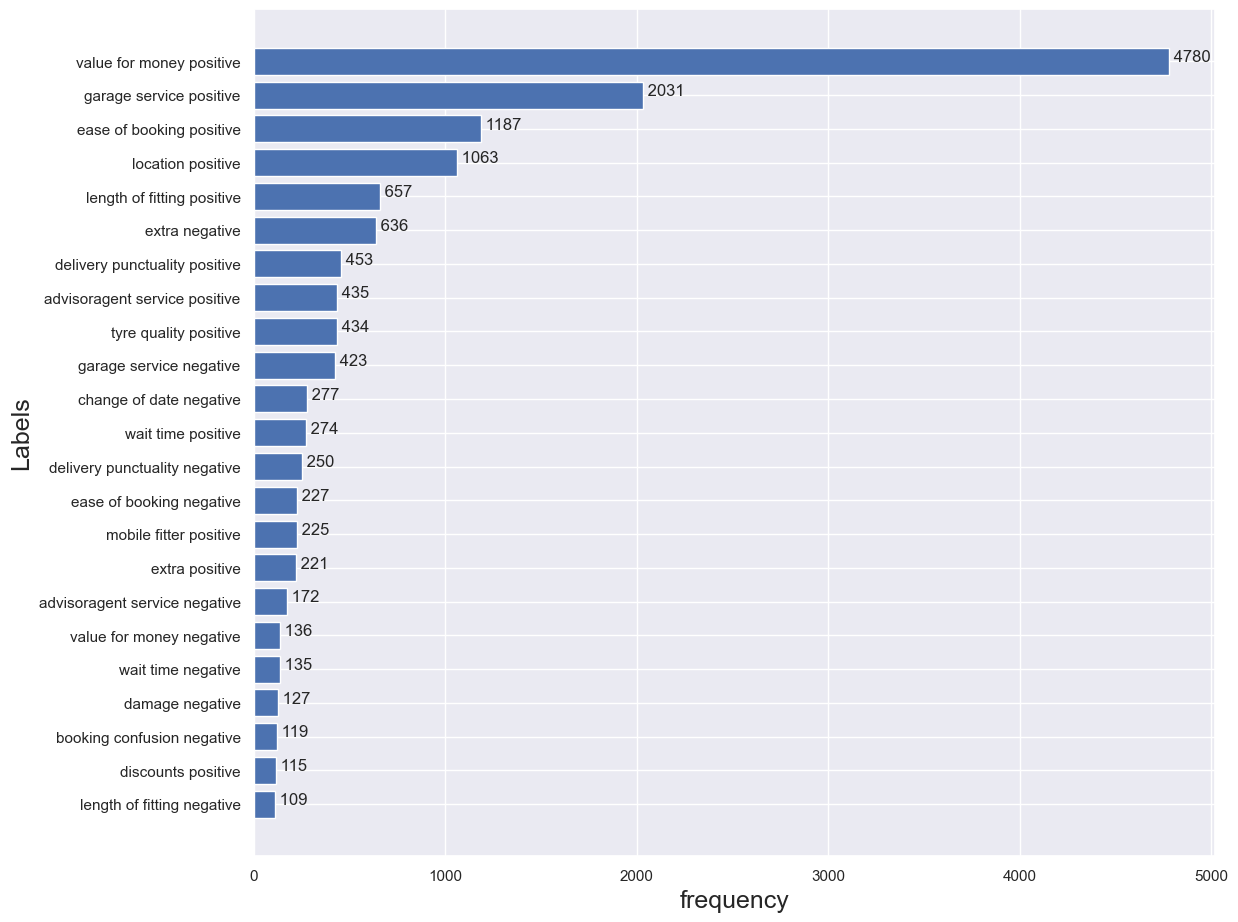

In [13]:
d = dict(Counter(df.target.explode()))
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}

sns.set(rc={'figure.figsize':(12.4,11.00)})
plt.barh(range(len(d)), d.values(), align='center')
plt.yticks(range(len(d)), d.keys())
plt.xlabel('frequency', fontsize=18)
plt.ylabel('Labels', fontsize=18)

for index, value in enumerate(d.values()):
    plt.text(value, index, ' '+str(value))

plt.show()


#### So we have aggregated all the labels that have frequency less than 100 to 'extra positive' and 'extra negative', and words like 'value for money positive' and 'garage service positive' have relatively significant frequency as compared to other labels, we can undersample those. 

In [14]:
print("Number of Unique Labels after all processing - {}".format(len(d)))

Number of Unique Labels after all processing - 23


#### We now have 23 labels after merging less common labels and removing some duplicates.We now have 23 labels after merging less common labels and removing some duplicates.

## Under Sampling Analysis

In [15]:
print("Number of Rows after removing datapoint with 0 labels and noisy labels - {}".format(df.shape[0]))


Number of Rows after removing datapoint with 0 labels and noisy labels - 8124


### Undersampling Analysis for value for money positive label

In [16]:
udf = df[df.target.apply(lambda x: x == ['value for money positive'])]
print("Number of rows with only 'value for money positive' as Label - {} ".format(udf.shape[0]))


Number of rows with only 'value for money positive' as Label - 2143 


#### There are 2143 datapoints in which there is only one label that is value for money positive, we can directly undersample these

In [17]:
underSampleLabel = udf.sample(frac=0.2)
indexesToDrop = udf.index.values
indexesToDrop = [idx for idx in indexesToDrop if idx in df.index]
df = df.drop(index=indexesToDrop)
df = pd.concat([df,underSampleLabel], ignore_index=True)
print("Number of Rows After undersampling 'value for money positive' - {}".format(df.shape[0]))


Number of Rows After undersampling 'value for money positive' - 6410


#### After Removing 90% of single occuring value for money positive label we have 3821 datapoints

### Undersampling Analysis for garage service positive label

In [18]:
udf = df[df.target.apply(lambda x: x == ['garage service positive'])]
print("Number of rows with only 'garage service positive' as Label - {} ".format(udf.shape[0]))


Number of rows with only 'garage service positive' as Label - 558 


#### There are 312 datapoints in which there is only one label that is 'garage service positive', we can directly undersample these

In [19]:
indexesToDrop = udf.index.values.tolist()
underSampleLabel = udf.sample(frac = 0.2,random_state=42)
try:
    df = df.drop(indexesToDrop)
except KeyError as e:
    print(f"Error: {e}. One or more index values to drop do not exist in the DataFrame.")
"""try:
    df = pd.concat([df, underSampleLabel], ignore_index=True)
except ValueError as e:
    print(f"Error: {e}. Unable to concatenate DataFrames.")"""
print("Number of rows after undersampling 'garage service positive' - {}".format(df.shape[0]))


Number of rows after undersampling 'garage service positive' - 5852


#### After Removing 80% of single occuring garage service positive label we have 3259 datapoints

### Undersampling Analysis for value for money positive, garage service positive label together

In [20]:
udf = df[df.target.apply(lambda x: x == ['value for money positive','garage service positive'])]
print("Number of rows with both 'value for money positive' and 'garage service positive' as Label - {} ".format(udf.shape[0]))


Number of rows with both 'value for money positive' and 'garage service positive' as Label - 232 


In [21]:
indexesToDrop = udf.index.values.tolist()
underSampleLabel = udf.sample(frac = 0.2, random_state=42)
df =df.drop(index = indexesToDrop,errors ='ignore')
try:
    df = pd.concat([df,underSampleLabel],ignore_index=True)
except AttributeError as e:
    print(f"Error: {e}. 'DataFrame' object has no attribute 'concat'.")
except Exception as e:
    print(f"Error: {e}")
print("Number of rows after undersampling 'value for money positive' and 'garage service positive' together - {}".format(df.shape[0]))

Number of rows after undersampling 'value for money positive' and 'garage service positive' together - 5666


#### After Undersampling of most frequent occuring labels we have 5587 datapoints 

## Final Distribution of Labels

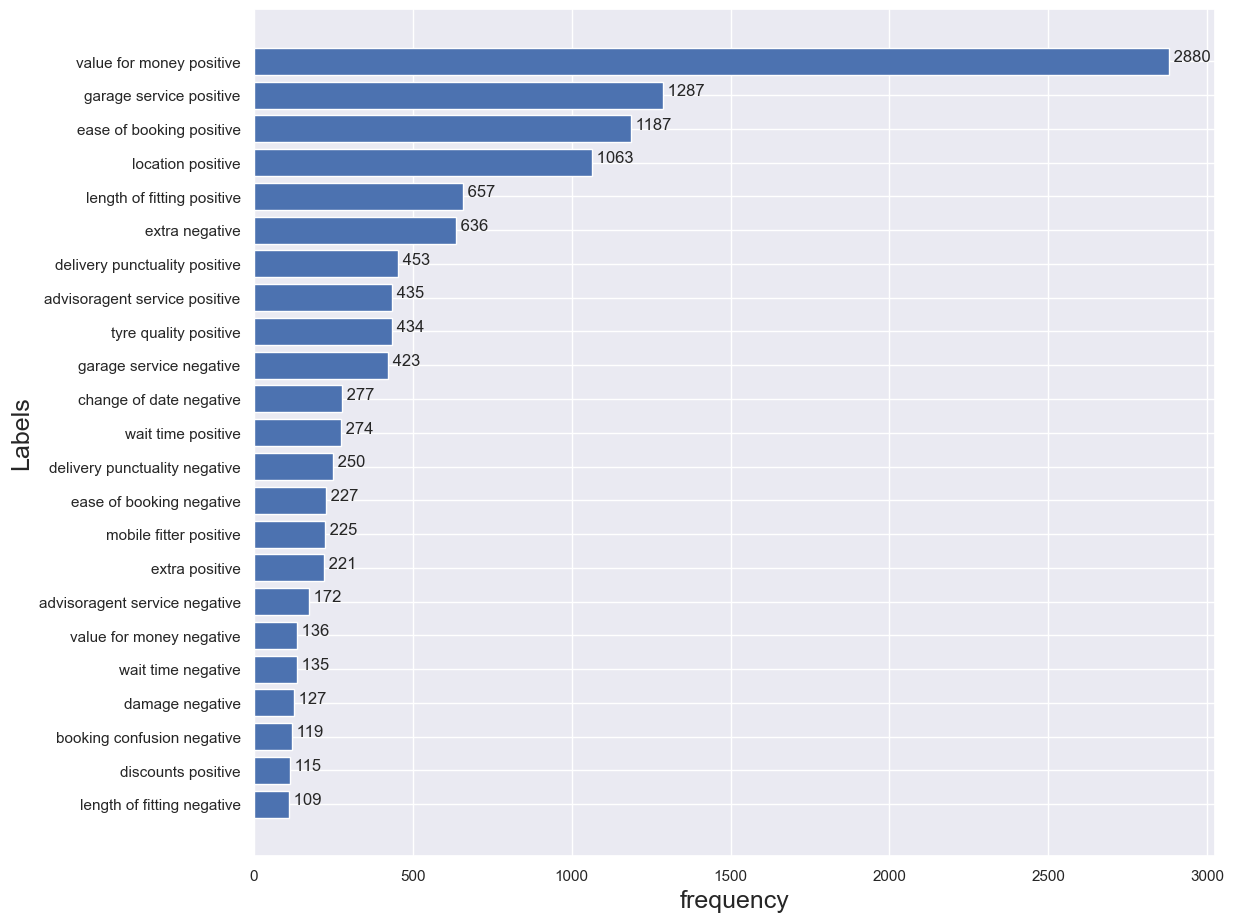

In [22]:
d = dict(Counter(df.target.explode()))
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}

sns.set(rc={'figure.figsize':(12.4,11.00)})
plt.barh(range(len(d)), d.values(), align='center')
plt.yticks(range(len(d)), d.keys())
plt.xlabel('frequency', fontsize=18)
plt.ylabel('Labels', fontsize=18)

for index, value in enumerate(d.values()):
    plt.text(value, index, ' '+str(value))

plt.show()


#### We have reduced the most frequently occuring labels significantly 

## Distibution of Token Lengths of Texts 

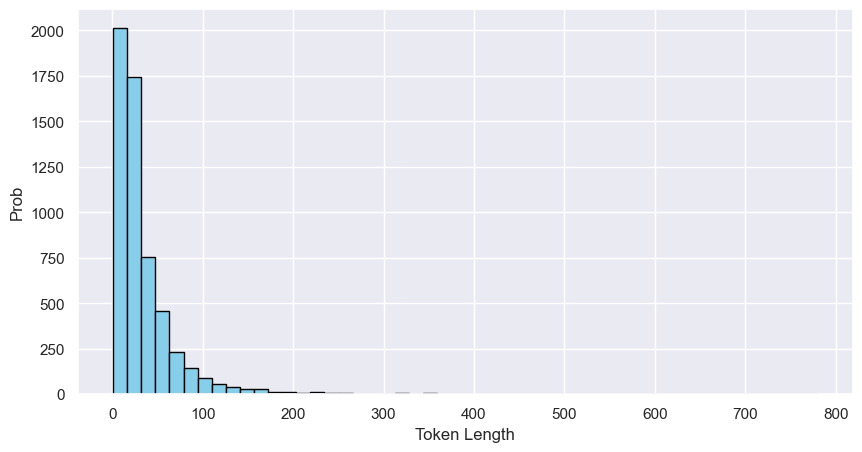

In [23]:
token_lengths = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))

# Plot the distribution of token lengths
plt.figure(figsize=(10, 5))
plt.hist(token_lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Token Length')
plt.ylabel('Prob')
plt.grid(True)
plt.show()

#### Most of the tokens length will come under 128